 master-thesisInput:
- True Observations
- Number Training Steps

Output:
- New Model Parameter

Parts of Optimization:
- Initialization of Model Parameter
- tbd

# Initialization

## Import Libraries and Mount Drive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
from torch import distributions, optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/master-thesis

import sys
sys.path.append('/content/gdrive/My Drive/GitHub/master-thesis')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/GitHub/master-thesis


In [2]:
%cd ..

/home/anuarsantoyo/PycharmProjects/master-thesis


In [3]:
from model.methods import *
from model.modelcore import epid_model
from model.modelhelper import *
from clustering.utils import *

## Optimization Settings

In [4]:
observation = 'hospitalization' #'newly_infected' #'hospitalization'
rolling_avg_obs = 1
# Overall Time Period
start_time='2020-08-01' # Mitte November/ Anfang Dezember bis Februar
end_time='2021-02-01' # Begin Vaccination Wave


dtype = torch.float32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #cuda:0

## Initialize Observations

In [5]:
df_obs_initial = pd.read_csv('data/observations.csv' , sep=';', thousands='.', decimal=',', encoding='utf-8', parse_dates=['Date'])

# Initialize Observations Training
df_obs, initial_newly_infected = initialize_observations(df_obs_initial, start=start_time, end=end_time, rolling_avg=rolling_avg_obs)
observed_train = torch.tensor(df_obs[observation], requires_grad=False, device=device, dtype=dtype)

df_obs.head(3)

,Date,number_of_deaths,newly_infected,hospitalization
0,2020-08-01,0.0,64.0,4.0
1,2020-08-02,0.0,78.0,2.0
2,2020-08-03,0.0,117.0,7.0


In [7]:
#for column in df_obs.columns:
#  plt.plot(df_obs['Date'], df_obs[column])
#  plt.title(column)
#  plt.show()

# Experiment Settings

In [6]:
method_type = 'linear'
#method_type = 'nn'

input_type = 'factor_data'
#input_type = 'group_data'
#input_type = 'mobility_data'

# Load Input Data

In [7]:
if input_type == 'factor_data':
  input_data_cols = ['F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice']
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/fa_data_model_input.csv', rolling_avg=1, input_data_cols=input_data_cols)

elif input_type == 'group_data':
  input_data_cols = ''
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/group_percentage_non_careful.csv', rolling_avg=7, input_data_cols=None)
elif input_type == 'mobility_data':
  input_data_cols = ['google_workplaces', 'google_residential', 'google_transit'] #['apple_driving', 'apple_walking', 'apple', 'google_retail', 'google_grocery', 'google_workplaces', 'google_residential', 'google_transit', 'google', 'telco', 'applegoogle']
  input_data = get_model_input(start=start_time, end=end_time, split_date=None, path='data/modeling/mobility_data_denmark.csv', rolling_avg=7, input_data_cols=input_data_cols)
input_data_size = input_data.shape[1]
input_data_size

5

In [10]:
#df_mob = pd.read_csv('data/modeling/mobility_data.csv')
#df_mob.date = pd.to_datetime(df_mob.date, format='%Y-%m-%d')
#df_mob = df_mob[df_mob['region'] == 'denmark'].reset_index(drop=True)
#df_mob.drop(columns=['region'], inplace=True)
#df_mob.to_csv('data/modeling/mobility_data_denmark.csv', index=False)
#df_mob.head()

## Initialize Model Parameter

### Initialize helper parameter

In [8]:
cero = torch.tensor(0., requires_grad=False, device=device, dtype=dtype)

### Initialize method parameter

In [9]:
if method_type == 'linear':
  method = Linear(device=device, dtype=dtype, input_size=input_data_size)
  
elif method_type == 'nn':
  method = NN(device=device, dtype=dtype, input_size=input_data_size)

### Initialize alpha and phi

In [10]:
dict_param = initialize_parameter(['alpha', 'phi'], device, dtype)
dict_param

{'prime_values': {'alpha': tensor(0.0102, requires_grad=True),
  'phi': tensor(-0.0020, requires_grad=True)},
 'real_values': {'alpha': tensor(0.0280, grad_fn=<AddBackward0>),
  'phi': tensor(25., grad_fn=<AddBackward0>)}}

# Optimization

## Training

In [12]:
from torch.optim.lr_scheduler import ExponentialLR
dict_params = {}
for meta_epoch in range(1, 100):
    print('Meta Epoch: ', meta_epoch)
    method = Linear(device=device, dtype=dtype, input_size=input_data_size)
    epochs = 100

    params_to_be_optimized = method.get_parameters() + [dict_param['prime_values']['phi']]
    if observation == 'hospitalization':
      params_to_be_optimized = params_to_be_optimized + [dict_param['prime_values']['alpha']]

    optimizer = optim.Adam(params_to_be_optimized, lr=0.01)
    scheduler = ExponentialLR(optimizer, gamma=0.999)



    for i in range(epochs):
      iteration_time = time.time()
      optimizer.zero_grad()

      # transform alphi, phi
      dict_param = transform_prime_variables(dict_param)

      # forward pass
      expected = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

      # calc loss
      comparison_loss_train =  calc_mse(expected, observed_train) * dict_param['real_values']['phi'] #calc_negative_binomnial_loss(expected, observed_train, dict_param['real_values']['phi']) #
      method_loss = method.calculate_loss()
      model_param_loss = calc_prior_loss(dict_param, device, dtype)
      loss = comparison_loss_train + method_loss + model_param_loss

      # backward pass
      loss.backward()
      optimizer.step()
      scheduler.step()


      with torch.no_grad():
        if i+1 % 40==0:
            current_time = round((time.time() - iteration_time),4)
            current_lr = optimizer.state_dict()['param_groups'][0]['lr']
            print(f"Step: {i}, Learning Rate: {current_lr} Time: {current_time}, Comparison Loss: {comparison_loss_train}. Method Loss: {method_loss}")
            plt.plot(df_obs['Date'], method.calculate_R(input_data).cpu().detach().numpy(), label='R')
            plt.plot(df_obs['Date'], input_data, label='input_data')
            plt.legend()
            plt.show()
        if i+1 % 40==0:
          plt.plot(df_obs['Date'], expected.cpu().detach().numpy(), label='predicted')
          plt.plot(df_obs['Date'], observed_train.cpu().detach().numpy(), label='observed')
          plt.legend()
          plt.show()
          plt.plot()

    with torch.no_grad():
        dict_params[meta_epoch] = method.get_parameters()



Meta Epoch:  1
Meta Epoch:  2
Meta Epoch:  3
Meta Epoch:  4
Meta Epoch:  5
Meta Epoch:  6
Meta Epoch:  7
Meta Epoch:  8
Meta Epoch:  9
Meta Epoch:  10
Meta Epoch:  11
Meta Epoch:  12
Meta Epoch:  13
Meta Epoch:  14
Meta Epoch:  15
Meta Epoch:  16
Meta Epoch:  17
Meta Epoch:  18
Meta Epoch:  19
Meta Epoch:  20
Meta Epoch:  21
Meta Epoch:  22
Meta Epoch:  23
Meta Epoch:  24
Meta Epoch:  25
Meta Epoch:  26
Meta Epoch:  27
Meta Epoch:  28
Meta Epoch:  29
Meta Epoch:  30
Meta Epoch:  31
Meta Epoch:  32
Meta Epoch:  33
Meta Epoch:  34
Meta Epoch:  35
Meta Epoch:  36
Meta Epoch:  37
Meta Epoch:  38
Meta Epoch:  39
Meta Epoch:  40
Meta Epoch:  41
Meta Epoch:  42
Meta Epoch:  43
Meta Epoch:  44
Meta Epoch:  45
Meta Epoch:  46
Meta Epoch:  47
Meta Epoch:  48
Meta Epoch:  49
Meta Epoch:  50
Meta Epoch:  51
Meta Epoch:  52
Meta Epoch:  53
Meta Epoch:  54
Meta Epoch:  55
Meta Epoch:  56
Meta Epoch:  57
Meta Epoch:  58
Meta Epoch:  59
Meta Epoch:  60
Meta Epoch:  61
Meta Epoch:  62
Meta Epoch:  63
M

In [13]:
rows=[]
# Convert dictionary to dataframe
for key in dict_params:
  rows.append(np.concatenate((dict_params[key][0].cpu().detach().numpy(),dict_params[key][1].cpu().detach().numpy().reshape(-1,1)), axis=1).reshape(-1))

In [14]:
df_params = pd.DataFrame(rows)

In [15]:
df_params.columns = ['F0_cautious_behaviour', 'F1_perception_advice', 'F2_applicability_usefullness_advice', 'F3_behaviour_others', 'F4_consequence_advice', 'Bias']

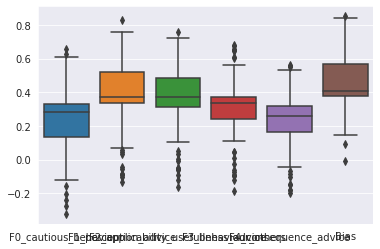

In [16]:
sns.boxplot(data=df_params)
plt.show()

In [15]:
comparison_loss_train / dict_param['real_values']['phi']

tensor(122.5926, grad_fn=<DivBackward0>)

In [25]:
method_loss

tensor(10.9100, grad_fn=<AddBackward0>)

# Evaluation

## Train and Test Time 

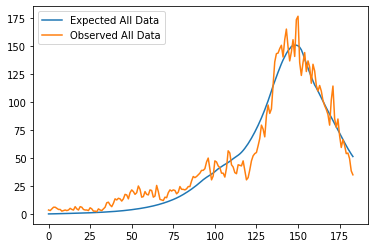

In [16]:
plt.plot(expected.cpu().detach().numpy(),label='Expected All Data')
plt.plot(observed_train.cpu().detach().numpy(),label='Observed All Data')
plt.legend()
plt.show()

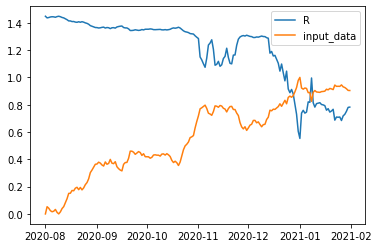

In [17]:
# Plot R-Value & Input Data
plt.plot(df_obs['Date'], method.calculate_R(input_data).cpu().detach().numpy(), label='R')
plt.plot(df_obs['Date'], input_data, label='input_data')
plt.legend()
plt.show()

## Eval What IF

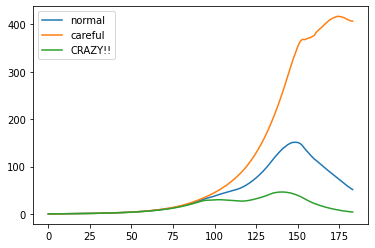

In [18]:
expected_normal = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_careful= epid_model(R=method.calculate_R(input_data*0.9), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]
expected_crazy = epid_model(R=method.calculate_R(input_data*1.1), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)[observation]

plt.plot(expected_normal.cpu().detach().numpy(),label='normal')
plt.plot(expected_careful.cpu().detach().numpy(),label='careful')
plt.plot(expected_crazy.cpu().detach().numpy(),label='CRAZY!!')
plt.legend()
plt.show()

# Eval Input Data - R-Value

In [19]:
if method_type == 'linear':
  print(set(method.model.parameters()))

Slope: -0.6845297552678737, intercept: 1.5807231225648728, r-squared: 0.7120081553387203


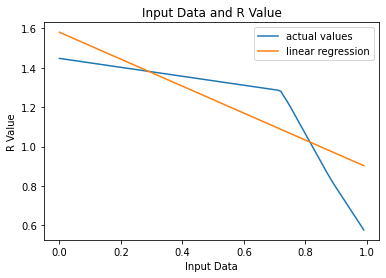

In [20]:
range = np.arange(0,1, 0.01)

if input_data_size == 1:
  from scipy import stats

  x = range
  y = np.squeeze(method.calculate_R(x).cpu().detach().numpy())

  slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
  y_linreg = intercept + slope * x
  print(f'Slope: {slope}, intercept: {intercept}, r-squared: {r_value**2}')
  plt.plot(x, y, label='actual values')
  plt.plot(x, y_linreg, label='linear regression')
  plt.xlabel('Input Data')
  plt.ylabel('R Value')
  plt.title('Input Data and R Value')
  plt.legend()
  plt.show()

elif input_data_size == 2:
  from mpl_toolkits.mplot3d import axes3d
  from matplotlib import cm
  from matplotlib.ticker import LinearLocator

  x = range
  y = range
  X,Y = np.meshgrid(x,y)

  X_new = X.reshape(-1)
  Y_new = Y.reshape(-1)
  input_data_plot = np.stack([X_new, Y_new], axis=1)
  rvalue_plot = method.calculate_R(input_data_plot).cpu().detach().numpy().reshape(100,100)


  fig = plt.figure(figsize=(12,8))
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlabel(input_data_cols[0])
  ax.set_ylabel(input_data_cols[1])
  ax.set_zlabel('R-Value')

  # Plot the surface.
  surf = ax.plot_surface(X, Y, rvalue_plot, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

  # Customize the z axis.
  ax.zaxis.set_major_locator(LinearLocator(10))

  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)
  #fig.savefig("images/Factor01_RValue_Comparison_Linear.png")
  plt.show()

elif input_data_size == 3:
  range = np.arange(0,1.1, 0.1)

  x = range
  y = range
  z = range
  X,Y,Z = np.meshgrid(x,y,z)

  X_new = X.reshape(-1)
  Y_new = Y.reshape(-1)
  Z_new = Z.reshape(-1)
  input_data_plot = np.stack([X_new, Y_new, Z_new], axis=1)
  rvalue_plot = method.calculate_R(input_data_plot).cpu().detach().numpy().reshape(-1)

  import plotly.graph_objects as go

  fig = go.Figure(data=[go.Scatter3d(
      x=X_new,
      y=Y_new,
      z=Z_new,
      mode='markers',
      marker=dict(
          size=25,
          color=rvalue_plot,
          colorbar=dict(title="R-Value"),
          colorscale='Viridis',
          opacity=0.95
      )
  )])
  fig.update_layout(title={
          'text': "Relationship Factors and R Value for " + str(method.model)[:5],
          'y':0.9,
          'x':0.5,
          'xanchor': 'center',
          'yanchor': 'top'},
                    scene = dict(
                      xaxis_title=input_data_cols[0],
                      yaxis_title=input_data_cols[1],
                      zaxis_title=input_data_cols[2]),
                      width=1400, height=800,
                      margin=dict(r=0, b=0, l=0, t=0))
  #fig.write_html('images/3dplot_factor_rvalue_nn.html')
  fig.show()

Eval Newly Infected

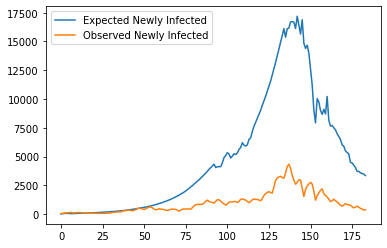

In [21]:
expected_newly = epid_model(R=method.calculate_R(input_data), initial_newly_infected = initial_newly_infected, alpha=dict_param['real_values']['alpha'], device=device, dtype=dtype)['newly_infected']

plt.plot(expected_newly.cpu().detach().numpy(),label='Expected Newly Infected')
plt.plot(df_obs['newly_infected'],label='Observed Newly Infected')
plt.legend()
plt.show()

## Save Calculated Hospitalisation


In [22]:
df_save = pd.DataFrame()
df_save['date'] = df_obs.Date
df_save['expected_hospitalisation'] = expected.cpu().detach().numpy()
df_save.head()

,date,expected_hospitalisation
0,2020-08-01,2.500000e-14
1,2020-08-02,1.184486e-02
2,2020-08-03,3.563496e-02
3,2020-08-04,7.666720e-02
4,2020-08-05,1.225350e-01


In [24]:
details = ''.join(filter(str.isalnum, str(input_data_cols)))
save_hosp_path = 'data/modeling/results/all_data/expected_hospitalizations_' + method_type + '_' + input_type + '_' + str(input_data_size) + '_' + details +'.csv'
save_model_path = 'data/modeling/results/models/all_data/model_' + method_type + '_' + input_type + '_' + str(input_data_size) + '_' + details + '.pt'
df_save.to_csv(save_hosp_path, index=False)
torch.save(obj=method, f=save_model_path)